In [43]:
!pip install lightgbm

In [44]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV

import eli5
from eli5.sklearn import PermutationImportance

In [45]:
# 필요한 데이터를 load 하겠습니다. 경로는 환경에 맞게 지정해주면 됩니다.
datafix = '/data/ephemeral/home/data/datafix.csv'

concat_select = pd.read_csv(datafix)

In [46]:
# 보간 전 상태 확인인
concat_select.isnull().sum()

아파트명                 2136
전용면적                    0
계약일                     0
층                       0
건축년도                    0
좌표X                     0
좌표Y                     0
target                  0
is_test                 0
계약년                     0
계약월                     0
avg_price_by_dong       0
한강근접여부                  0
동_rank                  0
dtype: int64

## 5. Model Training

- 이제 위에서 만든 파생변수들과 정제한 데이터를 기반으로 본격적으로 부동산 실거래가를 예측하는 모델링을 진행하겠습니다.
- 모델링에는 `sklearn`의 `RandomForest`를 이용하도록 하겠습니다.

- 참고 ✅
  - `RandomForest`는 배깅(Bagging)의 일종으로, 학습시키는 데이터 뿐 아니라 특성변수(X)들도 무작위로 선택해 트리를 생성하는 방법입니다.
  - 모델 학습 과정에서 서로 다른 N개의 Tree 생성하고, N개의 Tree에서 발생한 Output을 Voting(범주형, 분류문제)하거나, Average(연속형, 회귀문제)해 최종 Output 생성합니다.
  - 이는 High variance, Low bias 상황에서 분산(Variance) 감소에 도움을 줍니다.

In [47]:
# 이제 다시 train과 test dataset을 분할해줍니다. 위에서 제작해 놓았던 is_test 칼럼을 이용합니다.
dt_train = concat_select.query('is_test==0')
dt_test = concat_select.query('is_test==1')

# 이제 is_test 칼럼은 drop해줍니다.
dt_train.drop(['is_test'], axis = 1, inplace=True)
dt_test.drop(['is_test'], axis = 1, inplace=True)
print(dt_train.shape, dt_test.shape)

(1118812, 13) (9272, 13)


In [48]:
dt_test.head(1)

,아파트명,전용면적,계약일,층,건축년도,좌표X,좌표Y,target,계약년,계약월,avg_price_by_dong,한강근접여부,동_rank
1118812,개포6차우성,8.942595,26,5,1987,127.05721,37.476763,13250.0,2023,7,92107.125518,1,292


In [49]:
# dt_test의 target은 일단 0으로 임의로 채워주도록 하겠습니다.
dt_test['target'] = 0

### 5.1. 범주형 변수 Encoding
- 범주형 변수는 그대로 모델에 투입하면, 모델이 제대로 작동할 수 없습니다.
- 따라서 **레이블 인코딩 과정**을 통해 범주형 변수들을 numeric하게 바꾸는 인코딩 과정을 진행해주도록 하겠습니다.

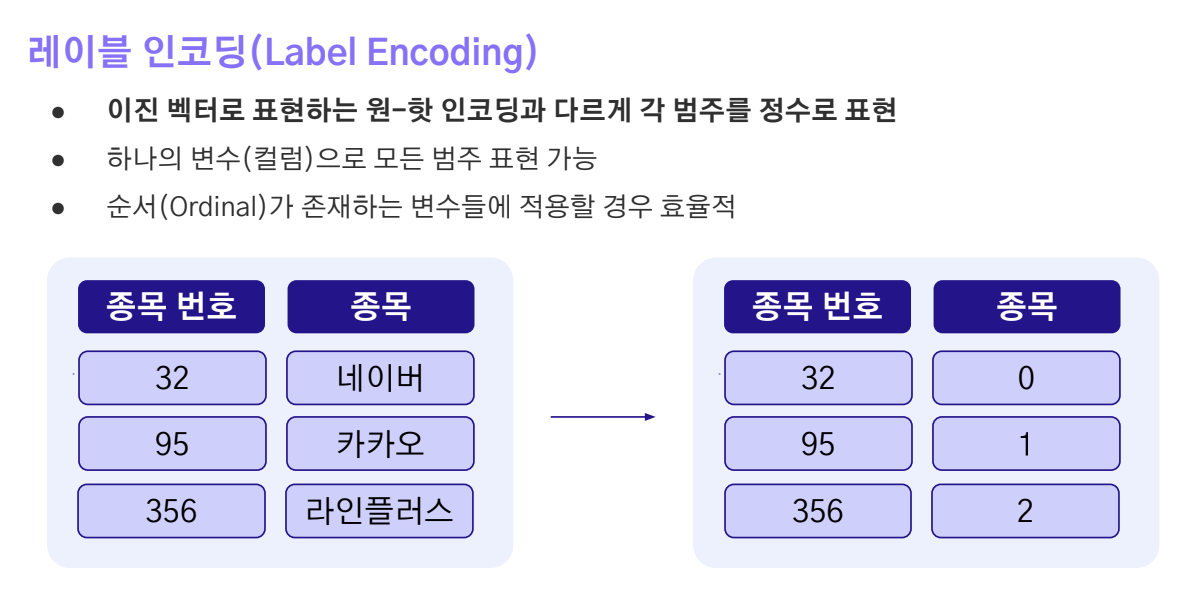

In [50]:
# # 구별 평균가격 rank 피처 아래 코드에서 drop으로 삭제예정
# # 바로 다음 블록 코드에서 동별 평균가격 rank 피처가 있는데, 그게 성능이 더 좋다

# mean_price_by_gu = dt_train.groupby('구')['target'].mean().sort_values()
# gu_rank = {gu: rank for rank, gu in enumerate(mean_price_by_gu.index, 1)}

# dt_train['구_rank'] = dt_train['구'].map(gu_rank)
# dt_test['구_rank'] = dt_test['구'].map(gu_rank)

# dt_train.drop('구', axis=1, inplace=True)
# dt_test.drop('구', axis=1, inplace=True)

In [51]:
# mean_price_by_dong = dt_train.groupby('동')['target'].mean().sort_values()
# dong_rank = {dong: rank for rank, dong in enumerate(mean_price_by_dong.index, 1)}

# dt_train['동_rank'] = dt_train['동'].map(dong_rank)
# dt_test['동_rank'] = dt_test['동'].map(dong_rank)

# dt_train.drop('동', axis=1, inplace=True)
# dt_test.drop('동', axis=1, inplace=True)

In [52]:
dt_train.columns

Index(['아파트명', '전용면적', '계약일', '층', '건축년도', '좌표X', '좌표Y', 'target', '계약년',
       '계약월', 'avg_price_by_dong', '한강근접여부', '동_rank'],
      dtype='object')

In [53]:
# 계약일 피처는 성능에 악영향을 끼치는것으로 보임. 계약년과 계약월이 있어서 삭제해도 괜찮을듯. 계약년과 계약월은 필수다
columns_to_drop = [
    '계약일'
]

dt_train = dt_train.drop(columns=columns_to_drop)
dt_test = dt_test.drop(columns=columns_to_drop)

In [54]:
# 파생변수 제작으로 추가된 변수들이 존재하기에, 다시한번 연속형과 범주형 칼럼을 분리해주겠습니다.
continuous_columns_v2 = []
categorical_columns_v2 = []

for column in dt_train.columns:
    if pd.api.types.is_numeric_dtype(dt_train[column]):
        continuous_columns_v2.append(column)
    else:
        categorical_columns_v2.append(column)

print("연속형 변수:", continuous_columns_v2)
print("범주형 변수:", categorical_columns_v2)

연속형 변수: ['전용면적', '층', '건축년도', '좌표X', '좌표Y', 'target', '계약년', '계약월', 'avg_price_by_dong', '한강근접여부', '동_rank']
범주형 변수: ['아파트명']


In [55]:
# EDA에 앞서 결측치를 확인해보겠습니다.
concat_select.isnull().sum()

아파트명                 2136
전용면적                    0
계약일                     0
층                       0
건축년도                    0
좌표X                     0
좌표Y                     0
target                  0
is_test                 0
계약년                     0
계약월                     0
avg_price_by_dong       0
한강근접여부                  0
동_rank                  0
dtype: int64

In [56]:
# 범주형 변수에 대한 보간
concat_select[categorical_columns_v2] = concat_select[categorical_columns_v2].fillna('NULL')

# 연속형 변수에 대한 보간 (선형 보간)
concat_select[continuous_columns_v2] = concat_select[continuous_columns_v2].interpolate(method='linear', axis=0)

In [57]:
# EDA에 앞서 결측치를 확인해보겠습니다.
concat_select.isnull().sum()

아파트명                 0
전용면적                 0
계약일                  0
층                    0
건축년도                 0
좌표X                  0
좌표Y                  0
target               0
is_test              0
계약년                  0
계약월                  0
avg_price_by_dong    0
한강근접여부               0
동_rank               0
dtype: int64

In [58]:
# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders = {}

# 범주형 변수에 대해 레이블 인코딩을 적용
for col in tqdm(categorical_columns_v2):
    lbl = LabelEncoder()

    # 학습 데이터와 테스트 데이터를 모두 문자열로 변환하여 처리
    dt_train[col] = dt_train[col].astype(str)
    dt_test[col] = dt_test[col].astype(str)
    
    # 학습 데이터에 대한 레이블 인코딩을 학습 및 변환
    lbl.fit(dt_train[col])
    dt_train[col] = lbl.transform(dt_train[col])
    label_encoders[col] = lbl  # 나중에 후처리를 위해 레이블 인코더 저장
    
    # Test 데이터에서 학습에 없었던 레이블을 추가하는 방식
    unseen_labels = np.setdiff1d(np.unique(dt_test[col]), lbl.classes_)
    
    # 새로운 레이블이 있으면 학습된 클래스에 추가
    if unseen_labels.size > 0:
        new_classes = np.concatenate([lbl.classes_, unseen_labels])
        lbl.classes_ = new_classes
    
    # Test 데이터에 변환을 적용
    dt_test[col] = lbl.transform(dt_test[col])


100%|██████████| 1/1 [00:00<00:00,  3.17it/s]


### 5.2. Model Training
- 위 데이터를 이용해 모델을 train 해보겠습니다. 모델은 XGBoost 이용하겠습니다.
- 마크다운에 RandomForest관련 사항은 삭선표시해두었습니다.

In [59]:
assert dt_train.shape[1] == dt_test.shape[1]          # train/test dataset의 shape이 같은지 확인해주겠습니다.

In [60]:
original_columns = dt_train.columns  # 원래 컬럼명 저장
column_mapping = {col: f"col_{i}" for i, col in enumerate(original_columns)}  # 간략한 영어 컬럼명 생성
reverse_mapping = {v: k for k, v in column_mapping.items()}  # 복원을 위한 매핑

In [61]:
# Target과 독립변수들을 분리해줍니다.
y_train = dt_train['target']
X_train = dt_train.drop(['target'], axis=1)

# 로그 변환
# y_train = np.log1p(dt_train['target'])
# y_train = np.log1p(dt_train['전용면적'])


# Hold out split을 사용해 학습 데이터와 검증 데이터를 8:2 비율로 나누겠습니다.
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2023)



In [62]:
import lightgbm as lgb

# 컬럼명 변경
X_train.rename(columns=column_mapping, inplace=True)
X_val.rename(columns=column_mapping, inplace=True)

# LightGBM Dataset 준비
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

In [65]:
# LightGBM 하이퍼파라미터 설정
params = {
    "objective": "regression",         # 회귀 문제로 설정
    "metric": "rmse",                  # RMSE를 평가 지표로 설정
    "boosting_type": "dart",           # 부스팅 방식
    "num_leaves": 31,                  # 리프 노드 개수
    "learning_rate": 0.05,             # 학습률
    "feature_fraction": 0.9,            # 사용할 피처 비율
    "n_estimator":1000,
    "device": "gpu", # GPU 사용 설정 
    "gpu_platform_id": 0, # GPU 플랫폼 설정 (기본값)
    "gpu_device_id": 0 # GPU 디바이스 설정 (기본값)

}

# 콜백 함수 설정 (조기 종료 및 로그 출력)
callbacks = [
    lgb.early_stopping(stopping_rounds=10),           # 조기 종료
    lgb.log_evaluation(period=10)                    # 10 라운드마다 로그 출력
]

# 모델 학습
model = lgb.train(
    params,
    train_set=train_data,
    valid_sets=[train_data, val_data],  # 학습 및 검증 데이터셋
    num_boost_round=100,               # 부스팅 반복 횟수
    callbacks=callbacks                # 콜백 함수
)

# 검증 데이터 예측
y_pred = model.predict(X_val, num_iteration=model.best_iteration)

# RMSE 계산
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"RMSE: {rmse:.4f}")

[LightGBM] [Warning] Unknown parameter: n_estimator
[LightGBM] [Warning] Unknown parameter: n_estimator
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1605
[LightGBM] [Info] Number of data points in the train set: 895049, number of used features: 11


LightGBMError: No OpenCL device found

# 모델 비교
이미 val pred RMSE가 위에 나와 있지만 그래도 보기 편하라고 한번 더 보여드림.

In [ ]:
pred = model.predict(X_val)
print(f'RMSE test: {np.sqrt(metrics.mean_squared_error(y_val, pred))}')

RMSE test: 13448.982970816813


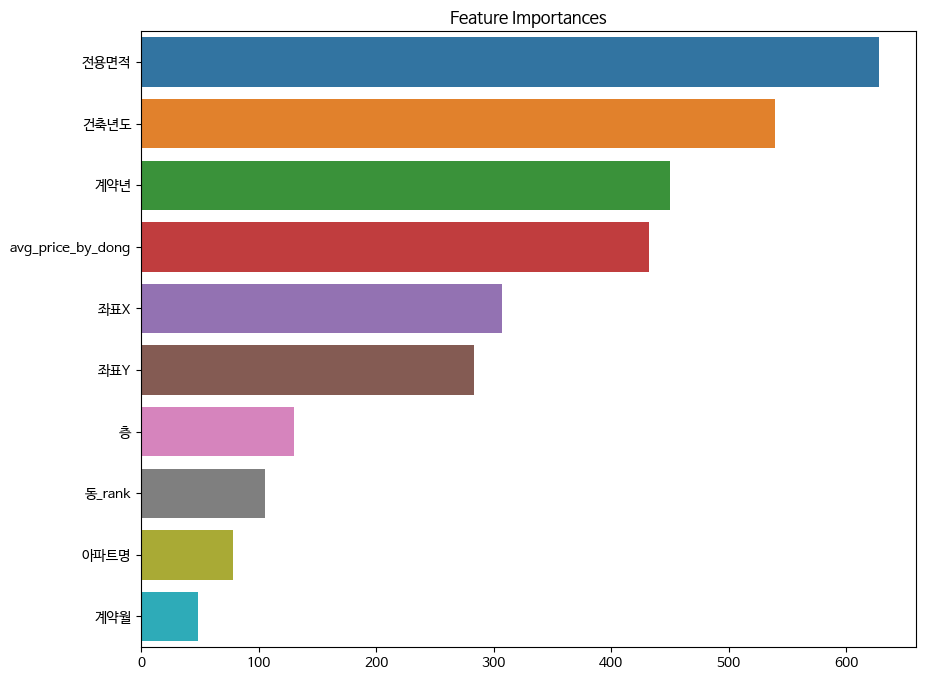

In [ ]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(model.feature_importance(), index=list(X_train.columns))
importances = importances.sort_values(ascending=False)


# 컬럼명을 원래 이름으로 복원
importances.index = [reverse_mapping[col] for col in importances.index]

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [183]:
# 학습된 모델을 저장합니다. Pickle 라이브러리를 이용하겠습니다.
with open('saved_model.pkl', 'wb') as f:
    pickle.dump(model, f)

### 5.3. Feature selection

- 어떤 변수가 유용한 변수인지 확인해보기 위해 permutation selection을 이용해보겠습니다.

In [ ]:
from lightgbm import LGBMRegressor

# LGBMRegressor 모델 학습
lgbm_model = LGBMRegressor(objective='regression', random_state=42)
lgbm_model.fit(X_train, y_train)

# Permutation Importance 계산
perm = PermutationImportance(lgbm_model,        # LGBMRegressor 모델을 사용
                             scoring='neg_mean_squared_error',  # 음의 평균 제곱 오차를 사용
                             random_state=42,
                             n_iter=3).fit(X_val, y_val)


# 컬럼명을 원래 이름으로 복원
original_feature_names = [reverse_mapping[col] for col in X_val.columns]

# 결과 시각화
eli5.show_weights(perm, feature_names=original_feature_names, top=len(X_val.columns))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1600
[LightGBM] [Info] Number of data points in the train set: 895049, number of used features: 10
[LightGBM] [Info] Start training from score 58006.352721


Weight,Feature
955505334.3804 ± 9656068.8938,계약년
937515703.8417 ± 5821735.9928,전용면적
793791504.3484 ± 1975599.0943,avg_price_by_dong
196172883.3501 ± 1601523.6058,건축년도
105805905.0569 ± 2267205.3830,좌표Y
79920872.2842 ± 1095374.3655,좌표X
31653331.0630 ± 485631.3753,동_rank
23575824.0179 ± 600753.9331,층
16109693.5731 ± 45318.8497,아파트명
15348509.5477 ± 426933.4403,계약월


### 5.4. Valid prediction 분석

- 예측값을 분석해보기 위해 valid prediction을 확인해보겠습니다.

In [185]:
X_val.columns = [reverse_mapping.get(col, col) for col in X_val.columns]

# Validation dataset에 target과 pred 값을 채워주도록 하겠습니다.
X_val['target'] = y_val
X_val['pred'] = pred

In [186]:
# Squared_error를 계산하는 함수를 정의하겠습니다.
def calculate_se(target, pred):
    squared_errors = (target - pred) ** 2
    return squared_errors

# RMSE 계산
squared_errors = calculate_se(X_val['target'], X_val['pred'])
X_val['error'] = squared_errors


In [187]:
# Error가 큰 순서대로 sorting 해 보겠습니다.
X_val_sort = X_val.sort_values(by='error', ascending=False)       # 내림차순 sorting

In [188]:
X_val_sort.head()

,아파트명,전용면적,층,건축년도,좌표X,좌표Y,계약년,계약월,avg_price_by_dong,동_rank,target,pred,error
288732,1848,15.078793,2,2019,127.009942,37.531536,2021,5,162187.609467,331,400000.0,840858.720105,1.943564e+11
288731,1848,15.439560,3,2019,127.009942,37.531536,2021,5,162187.609467,331,450000.0,841727.685600,1.534506e+11
534775,5930,15.645542,3,2011,127.009496,37.536978,2017,6,162187.609467,331,780000.0,469163.591721,9.661927e+10
381816,5931,13.700000,3,2015,127.012469,37.536403,2020,6,162187.609467,331,167000.0,462511.587806,8.732710e+10
240825,6209,15.658863,11,1979,127.028905,37.529934,2021,4,201732.389028,335,800000.0,504614.234047,8.725275e+10


- 예측을 잘 하지 못한 top 100개의 데이터와 예측을 잘한 top 100개의 데이터를 비교해보겠습니다.

In [189]:
X_val_sort_top100 = X_val.sort_values(by='error', ascending=False).head(100)        # 예측을 잘 하지못한 top 100개의 data
X_val_sort_tail100 = X_val.sort_values(by='error', ascending=False).tail(100)       # 예측을 잘한 top 100개의 data

In [190]:
# 해석을 위해 레이블인코딩 된 변수를 복원해줍니다.
error_top100 = X_val_sort_top100.copy()
for column in categorical_columns_v2 :     # 앞서 레이블 인코딩에서 정의했던 categorical_columns_v2 범주형 변수 리스트를 사용합니다.
    error_top100[column] = label_encoders[column].inverse_transform(X_val_sort_top100[column])

best_top100 = X_val_sort_tail100.copy()
for column in categorical_columns_v2 :     # 앞서 레이블 인코딩에서 정의했던 categorical_columns_v2 범주형 변수 리스트를 사용합니다.
    best_top100[column] = label_encoders[column].inverse_transform(X_val_sort_tail100[column])

In [ ]:
display(error_top100.head(5))
display(best_top100.head(1))

,아파트명,전용면적,층,건축년도,좌표X,좌표Y,계약년,계약월,avg_price_by_dong,동_rank,target,pred,error
288732,르가든더메인한남,15.078793,2,2019,127.009942,37.531536,2021,5,162187.609467,331,400000.0,840858.720105,1.943564e+11
288731,르가든더메인한남,15.439560,3,2019,127.009942,37.531536,2021,5,162187.609467,331,450000.0,841727.685600,1.534506e+11
534775,한남더힐,15.645542,3,2011,127.009496,37.536978,2017,6,162187.609467,331,780000.0,469163.591721,9.661927e+10
381816,한남동UNVILLAGE루하우스,13.700000,3,2015,127.012469,37.536403,2020,6,162187.609467,331,167000.0,462511.587806,8.732710e+10
240825,현대7차,15.658863,11,1979,127.028905,37.529934,2021,4,201732.389028,335,800000.0,504614.234047,8.725275e+10


,아파트명,전용면적,층,건축년도,좌표X,좌표Y,계약년,계약월,avg_price_by_dong,동_rank,target,pred,error
843546,삼성,7.744676,13,1999,127.017896,37.558169,2013,11,58375.462398,210,36000.0,36004.244819,18.018491


- 이제 분포를 비교해보도록 하겠습니다.

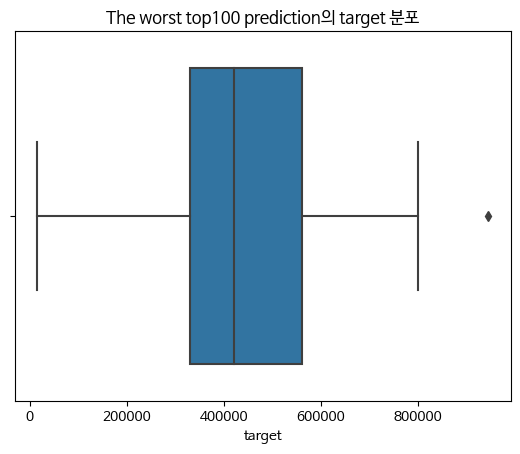

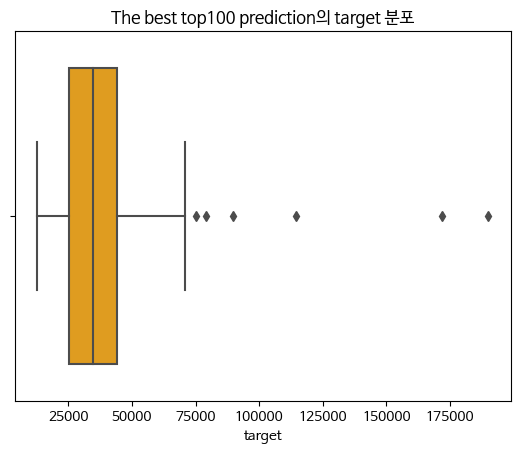

In [ ]:
sns.boxplot(data = error_top100, x='target')
plt.title('The worst top100 prediction의 target 분포')
plt.show()

sns.boxplot(data = best_top100, x='target', color='orange')
plt.title('The best top100 prediction의 target 분포')
plt.show()

- Taget 분포를 보니 좋은 예측을 보인 top 100개의 data보다 상대적으로 나쁜 예측을 보인 top 100 dataset들이 높은 가격을 보였음을 확인할 수 있습니다. 이에 대한 모델링 및 처리가 필요해보입니다.

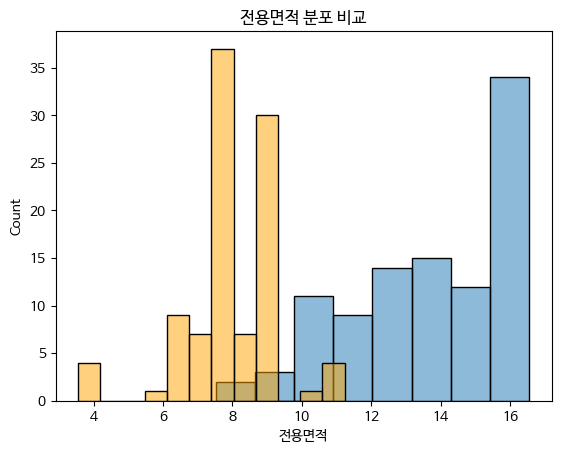

In [ ]:
sns.histplot(data = error_top100, x='전용면적', alpha=0.5)
sns.histplot(data = best_top100, x='전용면적', color='orange', alpha=0.5)
plt.title('전용면적 분포 비교')
plt.show()

- 전용면적 또한 나쁜 예측을 보인 집들이 더 넓음을 확인할 수 있습니다.

## 6. Inference

In [194]:
dt_test.head(2)      # test dataset에 대한 inference를 진행해보겠습니다.

,아파트명,전용면적,층,건축년도,좌표X,좌표Y,target,계약년,계약월,avg_price_by_dong,동_rank
1118812,328,8.942595,5,1987,127.057210,37.476763,0,2023,7,92107.125518,292
1118813,329,10.402005,10,2021,127.056394,37.484892,0,2023,8,92107.125518,292


In [195]:
# 저장된 모델을 불러옵니다.
with open('saved_model.pkl', 'rb') as f:
    model = pickle.load(f)

In [ ]:
%%time
X_test = dt_test.drop(['target'], axis=1)

# Test dataset에 대한 inference를 진행합니다.
real_test_pred = model.predict(X_test)

CPU times: user 497 ms, sys: 0 ns, total: 497 ms
Wall time: 13.3 ms


In [197]:
# real_test_pred = np.expm1(real_test_pred)
real_test_pred          # 예측값들이 출력됨을 확인할 수 있습니다.

array([203161.60926444, 279751.62020287, 297183.15612246, ...,
        92509.58132074,  86693.17217197,  82650.242606  ])

## 7. Output File Save

In [198]:
# 앞서 예측한 예측값들을 저장합니다.
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('output_LGBM.csv', index=False)